In [261]:
# Ucitavanje potrebnih biblioteka

import numpy as np 
import pandas as pd 
import zipfile
import os
import random
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from pathlib import Path

from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

import cv2
from sklearn.model_selection import train_test_split 

Učitavanje slika sa benignim cistama

In [290]:
file_path = 'Dataset_BUSI_with_GT/benign'
data_benign, masks_benign = [], []
for img in tqdm(os.listdir(file_path)):
    img_path = os.path.join(file_path, img)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    if 'mask' in img_path:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img_path[-5].isdigit():
            masks_benign[-1] = masks_benign[-1] + img
        else:
            masks_benign.append(img)
    else:
        data_benign.append(img)

100%|██████████| 891/891 [00:10<00:00, 84.80it/s] 


In [291]:
print(data_benign[0].shape)
print(masks_benign[0].shape)
print(len(data_benign))
print(len(masks_benign))

(128, 128, 3)
(128, 128)
437
437


Učitavanje slika sa malignim cistama

In [292]:
file_path = 'Dataset_BUSI_with_GT/malignant'
data_malignant, masks_malignant = [], []
for img in tqdm(os.listdir(file_path)):
    img_path = os.path.join(file_path, img)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    if 'mask' in img_path:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img_path[-5].isdigit():
            masks_malignant[-1] = masks_malignant[-1] + img
        else:
            masks_malignant.append(img)
    else:
        data_malignant.append(img)

100%|██████████| 421/421 [00:04<00:00, 88.46it/s] 


In [293]:
print(data_malignant[0].shape)
print(masks_malignant[0].shape)
print(len(data_malignant))
print(len(masks_malignant))

(128, 128, 3)
(128, 128)
210
210


Učitavanje normalnih skenova

In [294]:
file_path = 'Dataset_BUSI_with_GT/normal'
data_normal, masks_normal = [], []
for img in tqdm(os.listdir(file_path)):
    img_path = os.path.join(file_path, img)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    if 'mask' in img_path:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img_path[-5].isdigit():
            masks_normal[-1] = masks_normal[-1] + img
        else:
            masks_normal.append(img)
    else:
        data_normal.append(img)

100%|██████████| 266/266 [00:04<00:00, 60.69it/s]


In [295]:
print(data_normal[0].shape), print(masks_normal[0].shape)
print(len(data_normal)), print(len(masks_normal))

(128, 128, 3)
(128, 128)
133
133


(None, None)

Prikaz primera iz baze podataka

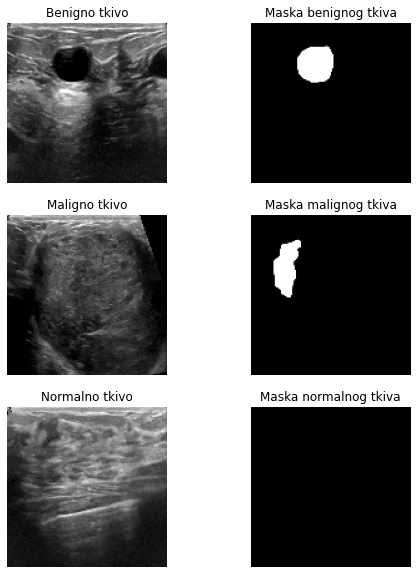

In [296]:
plt.figure(figsize=(8,10))
plt.subplot(3,2,1), plt.imshow(data_benign[54]), plt.title('Benigno tkivo'), plt.axis('off')
plt.subplot(3,2,2), plt.imshow(masks_benign[54], 'gray'), plt.title('Maska benignog tkiva'), plt.axis('off')
plt.subplot(3,2,3), plt.imshow(data_malignant[102]), plt.title('Maligno tkivo'), plt.axis('off')
plt.subplot(3,2,4), plt.imshow(masks_malignant[102], 'gray'), plt.title('Maska malignog tkiva'), plt.axis('off')
plt.subplot(3,2,5), plt.imshow(data_normal[0]), plt.title('Normalno tkivo'), plt.axis('off')
plt.subplot(3,2,6), plt.imshow(masks_normal[0], 'gray'), plt.title('Maska normalnog tkiva'), plt.axis('off')
plt.show()

In [297]:
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(data_benign, masks_benign, test_size=0.2, random_state=42)
X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(data_malignant, masks_malignant, test_size=0.2, random_state=42)
X_train_n, X_test_n, Y_train_n, Y_test_n = train_test_split(data_normal, masks_normal, test_size=0.2, random_state=42)

In [298]:
X_train = np.concatenate((X_train_b, X_train_m, X_train_n), axis=0)
X_test = np.concatenate((X_test_b, X_test_m, X_test_n), axis=0)
Y_train = np.concatenate((Y_train_b, Y_train_m, Y_train_n), axis=0)
Y_test = np.concatenate((Y_test_b, Y_test_m, Y_test_n), axis=0)

In [299]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = np.asarray(X_train[s])
Y_train = np.asarray(Y_train[s])

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = np.asarray(X_test[s])
Y_test = np.asarray(Y_test[s])

In [312]:
def Conv2DBlock(inputs, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
                        
    return x

In [302]:
def EncoderMiniBlock(inputs, num_filters=32):
    
    x = Conv2DBlock(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    
    return x, p

In [303]:
def DecoderMiniBlock(prev_layer_input, skip_connection_input, num_filters=32):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(prev_layer_input)
    x = Concatenate()([x, skip_connection_input])
    x = Conv2DBlock(x, num_filters)

    return x

In [310]:
def UNetModel(input_shape, lr = 0.01):
    inputs = Input(input_shape)

    s1, p1 = EncoderMiniBlock(inputs, 64)
    s2, p2 = EncoderMiniBlock(p1, 128)
    s3, p3 = EncoderMiniBlock(p2, 256)
    s4, p4 = EncoderMiniBlock(p3, 512)

    b1 = Conv2DBlock(p4, 1024)

    d1 = DecoderMiniBlock(b1, s4, 512)
    d2 = DecoderMiniBlock(d1, s3, 256)
    d3 = DecoderMiniBlock(d2, s2, 128)
    d4 = DecoderMiniBlock(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    modelUnet = Model(inputs=inputs, outputs=outputs, name="OriginalUNET")

    optimizer = Adam(learning_rate = lr)
    modelUnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return modelUnet

In [305]:
modelUNet = UNetModel((128, 128, 3), lr = 0.01)
modelUNet.summary()

Model: "OriginalUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_64 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1104 (Conv2D)           (None, 128, 128, 16  448         ['input_64[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_854 (Batch  (None, 128, 128, 16  64         ['conv2d_1104[0][0]']            
 Normalization)                 )                                                      

In [ ]:
modelUNet = UNetModel((128, 128, 3), 0.01)
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss")]
results = modelUNet.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=25, callbacks=callbacks)

In [307]:
Y_pred = np.round(modelUNet.predict(X_test))

In [308]:
y1 = Y_pred.flatten()
y2 = Y_test.flatten()

accuracy_score(y1, y2)

0.3180071593849522

In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]
train_val_history = []
Y_pred_all = []

for lr in learning_rate:
    modelUNet = UNetModel((128, 128, 3), lr)
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_accuracy")]
    results = modelUNet.fit(X_train, Y_train, validation_split=0.1, batch_size=64, epochs=25, callbacks=callbacks)
    
    Y_pred = np.round(modelUNet.predict(X_test))
    
    y1 = Y_pred.flatten()
    y2 = Y_test.flatten()
    print('---------------')
    print(accuracy_score(y1, y2))
    print('---------------')
    
    train_val_history.append(results.history)
    Y_pred_all.append(Y_pred)

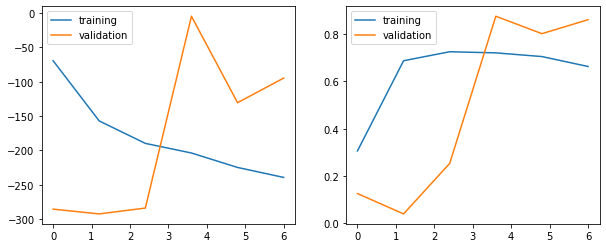

In [214]:
# lr = 0.0001
num = 0
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

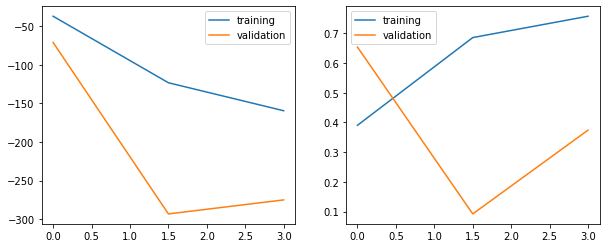

In [215]:
# lr = 0.001
num = 1
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

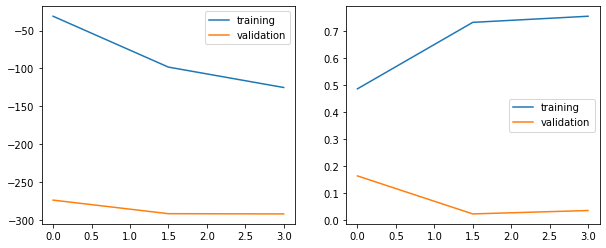

In [216]:
# lr = 0.01
num = 2
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

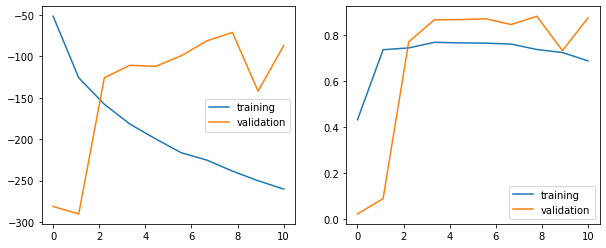

In [217]:
# lr = 0.1
num = 3
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()